# Radial basis function interpolation

> Getting a range of values from a few control points

## Setup

In [1]:
# python libraries require for the notebook to work properly
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = (20,10)  # change default size for plotted figures

In [2]:
# libraries used to display interactive 3D curves

#you need to install plotly chart-studio & pandas
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

## first of all, what is an interpolation ?

Interpolation is a type of estimation, a method of constructing new data points knowing discrete set of $N$ data points $\{x_i\}^N_{i=1} \in \mathbb{R}^n$ and their measurements $\{f_i\}^N_{i=1} \in \mathbb{R}$ .

we can also define that with a function $f:\mathbb{R}^n\rightarrow\mathbb{R}$ which is evaluated at the respective points $\{x_i\}^N_{i=1}$.

Interpolation differs from approximation, where approximation does not necessitate that our function exactly equals our measurements at our respective data points.

When accuracy at data points is not needed, approximation will be preferred over interpolation. Interpolation condition may be undesirable because it forces the interpolation to match exactly with potential measurement error, where approximation may provide a nicer function that smooth error influence and illustrate measured correlations better.

Our purpose here will be to use Radial basis function to create an interpolation function ($\Psi:\mathbb{R}^n\rightarrow\mathbb{R}$) that satisfy the interpolation condition below using a radial basis function ($\phi:\mathbb{R}\rightarrow\mathbb{R}$).

Interpolation Condition:

$$ \Psi(x_i)=f_i \quad/\quad \forall i \in 1\dots N $$

## Our radial basis function

A radial base function (RBF) is a $\phi$ function whose value depends on the distance between the input $x$ and a point that can be either the origin, in this case $phi(x)=\phi(\|x\|)$, or another fixed point $c$ , called the center, so that $\phi(x)=\phi(\|x-c\|)$.

### Some common RBF :

with $ {r=\left\|x\right\|}$ and $\epsilon$ a parameter used to scale our output

- <u>Gaussian</u> :
$$ {\Large \phi(r)=e^{-(\epsilon.r)^2}} $$

- Multiquadric:
$$ {\Large \phi (r)={\sqrt {1+(\epsilon.r)^2}}} $$

- Inverse quadratic:
$$ {\Large \phi (r)={\dfrac {1}{1+(\epsilon.r)^2}}} $$

- Inverse multiquadric:
$$ {\Large \phi (r)={\dfrac {1}{\sqrt {1+(\epsilon.r)^2}}}} $$


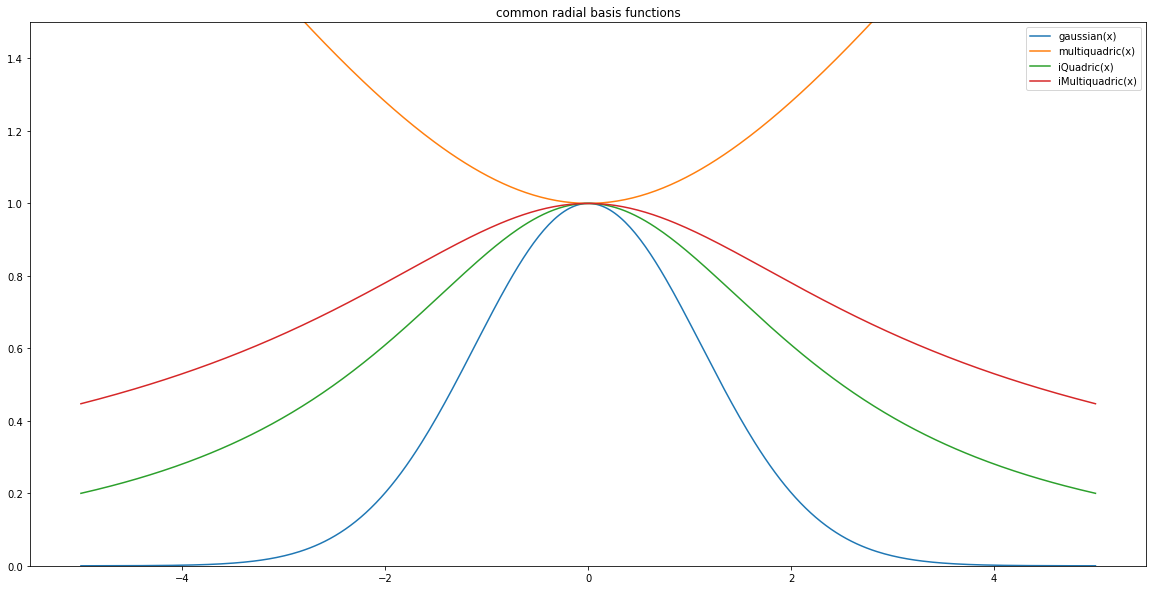

In [3]:
e = 0.4 # epsilon

# gaussian with 
def gaussian(x):
    return np.exp(-e*x*x)

# multiquadric
def multiquadric(x):
    return np.sqrt(1 + np.power(e*x,2))

# inverse quadric
def iQuadric(x):
    return 1/(1 + np.power(e*x,2))

# inverse multiquadric
def iMultiquadric(x):
    return 1/(np.sqrt(1 + np.power(e*x,2)))

x = np.linspace(-5, 5, 400)
r = np.absolute(x)

plt.plot(x, gaussian(r), label = 'gaussian(x)' )
plt.plot(x, multiquadric(r), label = 'multiquadric(x)' )
plt.plot(x, iQuadric(r), label = 'iQuadric(x)' )
plt.plot(x, iMultiquadric(r), label = 'iMultiquadric(x)' )

plt.title("common radial basis functions")
plt.ylim(0, 1.5)
plt.legend(loc="upper right")
plt.show()

## Let's build our interpolation in $\mathbb{R}$

### first approach
---
we have $N$ points $\{x_i\}^N_{i=1}$ where $\quad x_i \in \mathbb{R} \quad \forall i \in 1\dots N$

To create our interpolation we can first think of using directly a product between our radial function $\phi$ and our measurements $\{f_i\}^N_{i=1}$. This would respect the interpolation condition because when the value of any point is equal to one of our known points then the distance $\|x-x_i\|$ is zero and our radial function is equal to 1.

$$ \Psi(x) = \sum^N_{i=1} f_i.\phi(\|x-x_i\|)$$ 


This works really well when the number N of known points is equal to 1.

Here an exemple with $x_1= 1$ and $f_1 = 2$ using gaussian RBF

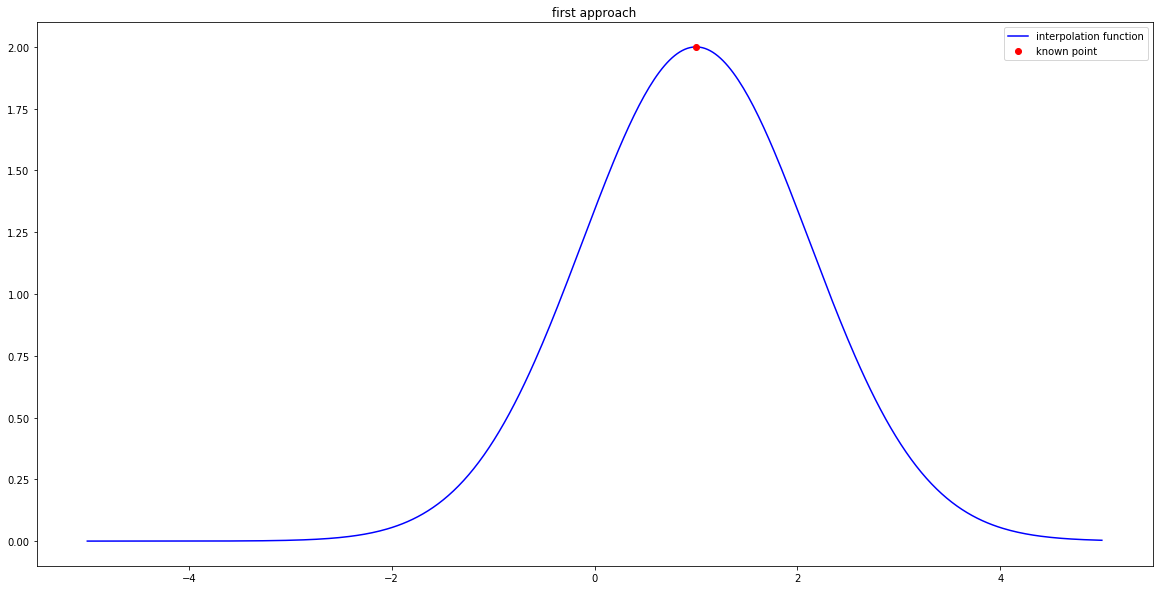

In [4]:
#Euclidean norm in R
def norm(x1, x2):
    return np.abs(x1 - x2)

x1 = 1
f1 = 2

def psi(x):
    return f1*gaussian(norm(x, x1))

plt.plot(x, psi(x), '-b', label = 'interpolation function')
plt.plot(x1, f1, 'or', label = 'known point')

plt.title('first approach')
plt.legend(loc='upper right')
plt.show()

But of course, for several known points, the condition $ \Psi(x_i)=f_i \;/\; \forall i \in 1\dots N $ is no longer respected since the values of the points are summed up as shown in the figure below.

with $f(0) = 1$ & $f(2) = 0.8$

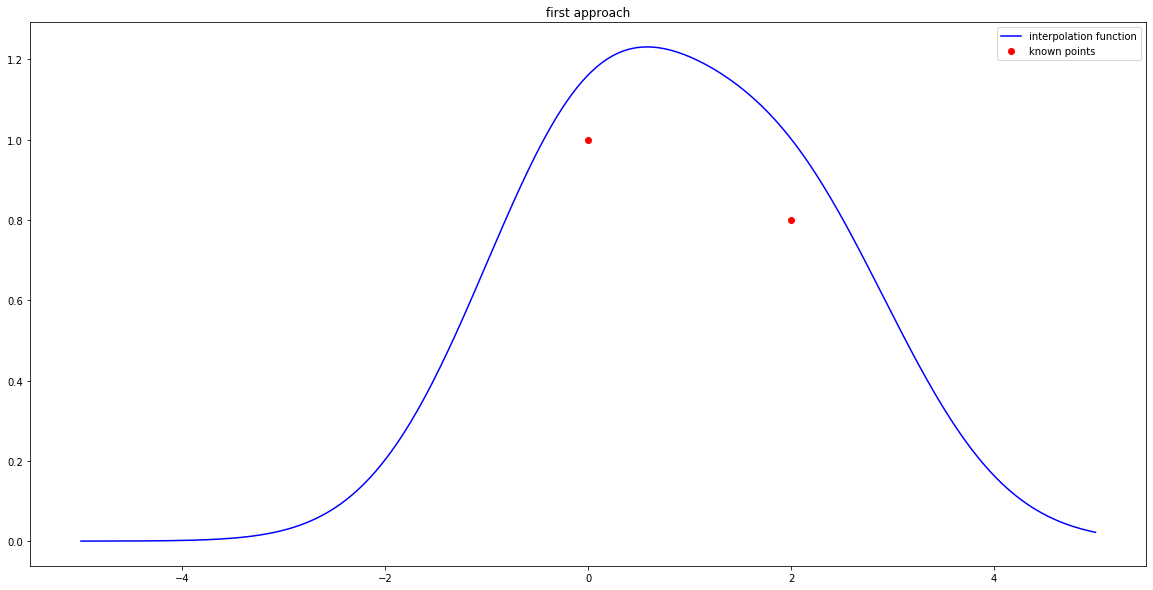

In [5]:
xi = np.array([0, 2])
fi = np.array([1, 0.8])

def psi(x, rbf, norm, xi, fi):
    psi = 0
    for i in range(xi.size):
        psi += fi[i]*rbf(norm(x, xi[i]))
    return psi

# vectorize our function to be used on an array of data instead of a single x value
vectorizedPsi = np.vectorize(psi)
# exclude the other parameters so that only parameter x is vectorized 
vectorizedPsi.excluded.update([1, 2, 3, 4])

# psi could also be written using a comprehension list without vectorization like this
# def psi(x, rbf, norm, xi, fi):
#     return [ np.sum([fi_*rbf(norm(x_, xi_)) for xi_, fi_ in zip(xi, fi)]) for x_ in x]

plt.plot(x, vectorizedPsi(x, gaussian, norm, xi, fi), '-b', label = 'interpolation function')
plt.plot(xi, fi, 'or', label = 'known points')

plt.title('first approach')
plt.legend(loc='upper right')
plt.show()

### Find our right interpolation
---

We will continue to use the assumption that our interpolation function ($\Psi:\mathbb{R}\rightarrow\mathbb{R}$) can be found by a linear combination of radial functions while satisfying the following interpolation condition :

$$ \Psi(x_i)=f_i \quad/\quad \forall i \in 1\dots N $$

let's write the new form of our interpolation function :

$$ \Psi(x) = \sum^N_{i=1}  \omega_i.\phi(\|x-x_i\|)$$


$$\fbox{ the $\omega_i$ are still unknown and we will have to determine them}$$

We have N constraints on the $\omega_i$ :

$$ \sum^N_{i=1} \omega_k.\phi(\|x_k-x_i\|) = f_k \quad \forall k \in 1\dots N $$

We can write this system of equations using a matrix as follows :

$$
\begin{bmatrix}
\phi(\|x_1-x_1\|) & \phi(\|x_1-x_2\|) & \phi(\|x_1-x_3\|) & \dots & \phi(\|x_1-x_N\|) \\
\phi(\|x_2-x_1\|) & \phi(\|x_2-x_2\|) & \phi(\|x_2-x_3\|) & \dots & \phi(\|x_2-x_N\|) \\
\dots  & \dots  & \dots  & \dots & \dots  \\
\phi(\|x_N-x_1\|) & \phi(\|x_N-x_2\|) & \phi(\|x_N-x_3\|) & \dots & \phi(\|x_N-x_N\|) \\
\end{bmatrix}
\begin{pmatrix}
\omega_1 \\ \omega_2 \\ \dots \\ \omega_N
\end{pmatrix}
=
\begin{pmatrix} 
f_1 \\ f_2 \\ \dots \\ f_N
\end{pmatrix}
$$

We can therefore define a linear system which is expressed as follows:

$$ M.\omega = \mathbf{f}$$


By using numerical methods and solving this linear system, we found our omega used in our interpolation function.

$$ \Rightarrow \omega = 
\begin{pmatrix}
\omega_1 \\ \omega_2 \\ \dots \\ \omega_N
\end{pmatrix}
=  M^{-1}.\mathbf{f}$$

---
$${\Large\text{Let's see an example}}$$
---

In [6]:
def computeOmega(xi, fi, rbf, norm):
    size = len(xi)
    M = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            M[i, j] = rbf(norm(xi[i], xi[j]))
            
    return np.linalg.solve(M, fi)

# define our interpolation using list comprehension
def psi(x, rbf, norm, xi, fi):
    wi = computeOmega(xi, fi, rbf, norm)
    return [ np.sum([wi_*rbf(norm(x_, xi_)) for xi_, wi_ in zip(xi, wi)]) for x_ in x]

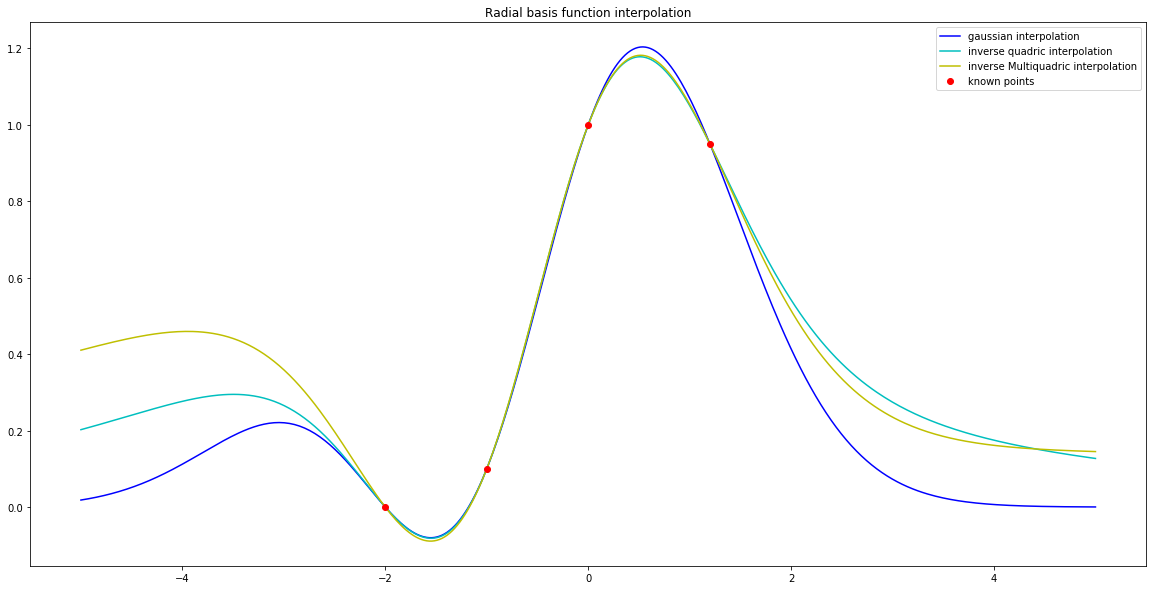

In [7]:
# define our known points and their measurements
xi = np.array([0, 1.2, -2, -1])
fi = np.array([1, 0.95, 0, 0.1])

plt.plot(x, psi(x, gaussian, norm, xi, fi), '-b', label = 'gaussian interpolation')
plt.plot(x, psi(x, iQuadric, norm, xi, fi), '-c', label = 'inverse quadric interpolation')
plt.plot(x, psi(x, iMultiquadric, norm, xi, fi), '-y', label = 'inverse Multiquadric interpolation')
plt.plot(xi, fi, 'or', label = 'known points')

plt.title('Radial basis function interpolation')
plt.legend(loc='upper right')
plt.show()

### And in N dimensions so ? ($\mathbb{R}^n$)
---

In n dimensions it is the same thinking  with the only difference that our $x_i$ are in $\mathbb{R}^n$

$$ \{x_i\}^N_{i=1} \in \mathbb{R}^n $$

The norm used to measure the distance between two points in a space of dimension N must be adapted. 

We note $\vec{x}$ as a vector $(x_{1},\dots ,x_{n}) \in \mathbb{R}^n$

For example,  **the Euclidean** norm defined by :

$$  \|\vec{x}\|_2 = \sqrt {|x_1^2|+\ldots +|x_n^2|} $$ 

We can also use other ways to measure a distance as with **the Manhattan distance** defined as follows:

$$  \|\vec{x}\|_1 = |x_1|+\ldots +|x_n| $$

more generally, for any $p \geq 1$, the **norm p** is given by the following formula :

$$  \|\vec{x}\|_p = \left(|x_1|^p+\ldots +|x_n|^p\right)^{\frac{1}{p}} $$

### Exemple in  $\mathbb{R}^2$
---

In [8]:
def euclideanNorm(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def ManhattanDist(a, b):
    return np.sum(np.abs(a - b))

def pNorm(a, b, p):
    return np.pow(np.sum((a - b) ** p), 1/p)

In [9]:
def generateSurfacePoints(minBound, maxBound, res):
    linspace = np.linspace(minBound, maxBound, res)
    # meshgrid makes N-D coordinate arrays for vectorized evaluations of N-D scalar/vector
    # used here to genere points on 2D grid
    X, Y = np.meshgrid(linspace, linspace)
    # np.dstack : function that converts the coordinates into the following shape: (2D grid)
    # [ [[p11.x, p11.y], [p12.x, p12.y], [p13.x, 13.y]],
    #   [[p21.x, p21.y], [p22.x, p22.y], [p23.x, 23.y]], ...]
    temp = np.dstack((X,Y))
    return X, Y, temp.reshape(-1,temp.shape[2]), linspace

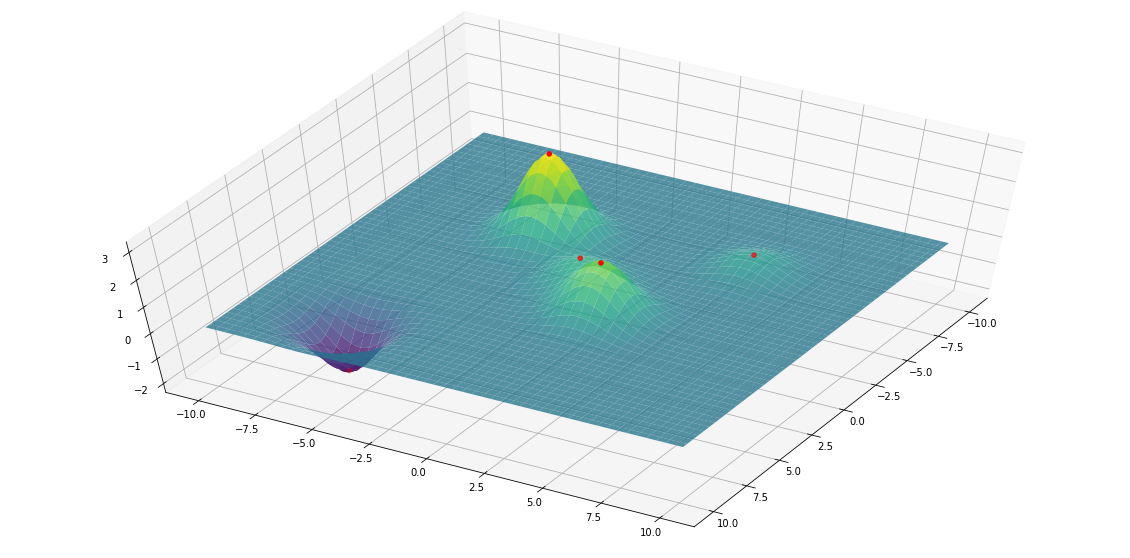

In [10]:
# define our known points and their measurements
xi = np.array([[0,0], [2,2], [-4,5], [-3,-3], [7,-6]])
fi = np.array([1, 2, 0.7, 3, -2])

fig = plt.figure()
ax = plt.axes(projection='3d') # define our 3D plot

X, Y, x2D, sideLinspace = generateSurfacePoints(-10, 10, 200)

# Our values are stored in a simple 1D array
interpolatedValues = np.array(psi(x2D, gaussian, euclideanNorm, xi, fi))

# they must be converted into a 2D array of values to display them with plot_surface
tempSize = math.floor(math.sqrt(len(interpolatedValues)))
convertedValues = interpolatedValues.reshape(tempSize, tempSize)

ax.scatter(xi[:, 0], xi[:, 1], fi, c='r', marker='o')
ax.plot_surface(X, Y, convertedValues, cmap='viridis', edgecolor='none',  alpha=0.8)

ax.view_init(60, 30) # rotate  our graph
plt.show()

---
# BONUS
using plotly for dynamic 3D plot

---

In [11]:
# allows you to draw a surface with plotly
def drawSurface(t, _x, _y, _z):
    layout = go.Layout( margin = dict( l=0, r=0, b=0, t=0 ))
    fig = go.Figure(data=[go.Surface(z=_z, x=_x, y=_y, opacity=0.8)], layout=layout)
    fig.update_layout(scene_aspectmode='data')
    fig.update_layout(title=t, autosize=True)
    return fig

# allows to draw points in space with plotly (on an existing figure passed as arguments)
def drawPts(fig, pts, u):
    fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=u, mode='markers'))
    return fig

In [12]:
# You need to install plotly to see these figures
fig = drawSurface('',sideLinspace, sideLinspace, convertedValues)
fig = drawPts(fig, xi, fi)
fig.show()

---
# Just For Fun
with **inverse Quadric** radial basis function and **Manhattan Distance** as norm

---

In [13]:

interpolatedValues = np.array(psi(x2D, iQuadric, ManhattanDist, xi, fi))

tempSize = math.floor(math.sqrt(len(interpolatedValues)))
convertedValues = interpolatedValues.reshape(tempSize, tempSize)

fig = drawSurface('',sideLinspace, sideLinspace, convertedValues)
fig = drawPts(fig, xi, fi)
fig.show()